In [68]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
from cProfile import label
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import random 

%matplotlib inline

In [69]:
def plot_degree_dist(G):
    
    degrees = [G.degree(n, weight = 'weight') for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=15)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=15)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    print(bin_edges)
    print(density)
    
    fig = plt.figure(figsize=(16,16))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [70]:

df = pd.read_csv('../data/taxon-exporter.csv', header=0)
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc

taxons = {}
purpose = {}
        
for index, row in df.iterrows():

    details = {"Appendix": row['Appendix'], "Class": row['Class'], "Order": row['Order'], "Family": row['Family'], "Genus": row['Genus']}
    
    if(row['Purpose'] == "B"):
        purposeCode = "Breeding"
    if(row['Purpose'] == "E"):
        purposeCode = "Educational"
    if(row['Purpose'] == "G"):
        purposeCode = "Garden"
    if(row['Purpose'] == "H"):
        purposeCode = "Hunting"
    if(row['Purpose'] == "L"):
        purposeCode = "Law"
    if(row['Purpose'] == "M"):
        purposeCode = "Medical"
    if(row['Purpose'] == "R"):
        purposeCode = "Reintroduction to wild"
    if(row['Purpose'] == "P"):
        purposeCode = "Personal"
    if(row['Purpose'] == "Q"):
        purposeCode = "Circus"
    if(row['Purpose'] == "S"):
        purposeCode = "Scientific"
    if(row['Purpose'] == "T"):
        purposeCode = "Commercial"
    if(row['Purpose'] == "Z"):
        purposeCode = "Zoo"
    if(row['Purpose'] == "Unspecified"):
        purposeCode = "Unspecified"
        
    attributes = {"Details": details}

    taxons.update({row['Taxon']: row['Taxon']})
    if G.has_node(row['Taxon']):
        if purposeCode not in G.nodes[row['Taxon']]['purpose']:  
            G.nodes[row['Taxon']]['purpose'].append(purposeCode)
    else:
        purpose = [purposeCode]
        G.add_node(row['Taxon'], **details, purpose = [purposeCode])

df2 = df.drop_duplicates(['Taxon', 'Exporter'])
for i, group in df2.groupby(['Exporter'])['Taxon']:
    # generate all combinations without replacement 
    # from the group of similar column pairs       
    for u, v in itertools.combinations(group, 2):
        if(G.has_edge(u,v)):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight = 1)

nx.write_gml(G, "taxon-taxon-exporter.gml")



Number of nodes:  1315
Number of edges:  391666

Weighted average degree: 1285.0463878326996
Minimum degree:  0
Maximum degree:  7641

[1.00000000e+00 2.23252558e+00 4.98417045e+00 1.11272880e+01
 2.48419550e+01 5.54603000e+01 1.23816538e+02 2.76423588e+02
 6.17122730e+02 1.37774228e+03 3.07584487e+03 6.86690234e+03
 1.53305351e+04 3.42258117e+04 7.64100000e+04]
[0.00000000e+00 0.00000000e+00 9.97908334e-04 4.46986294e-04
 5.00538828e-04 4.03565317e-04 6.67830935e-04 8.92912608e-04
 3.33464802e-04 9.34105455e-05 3.27449351e-05 2.71615114e-07
 0.00000000e+00 0.00000000e+00]


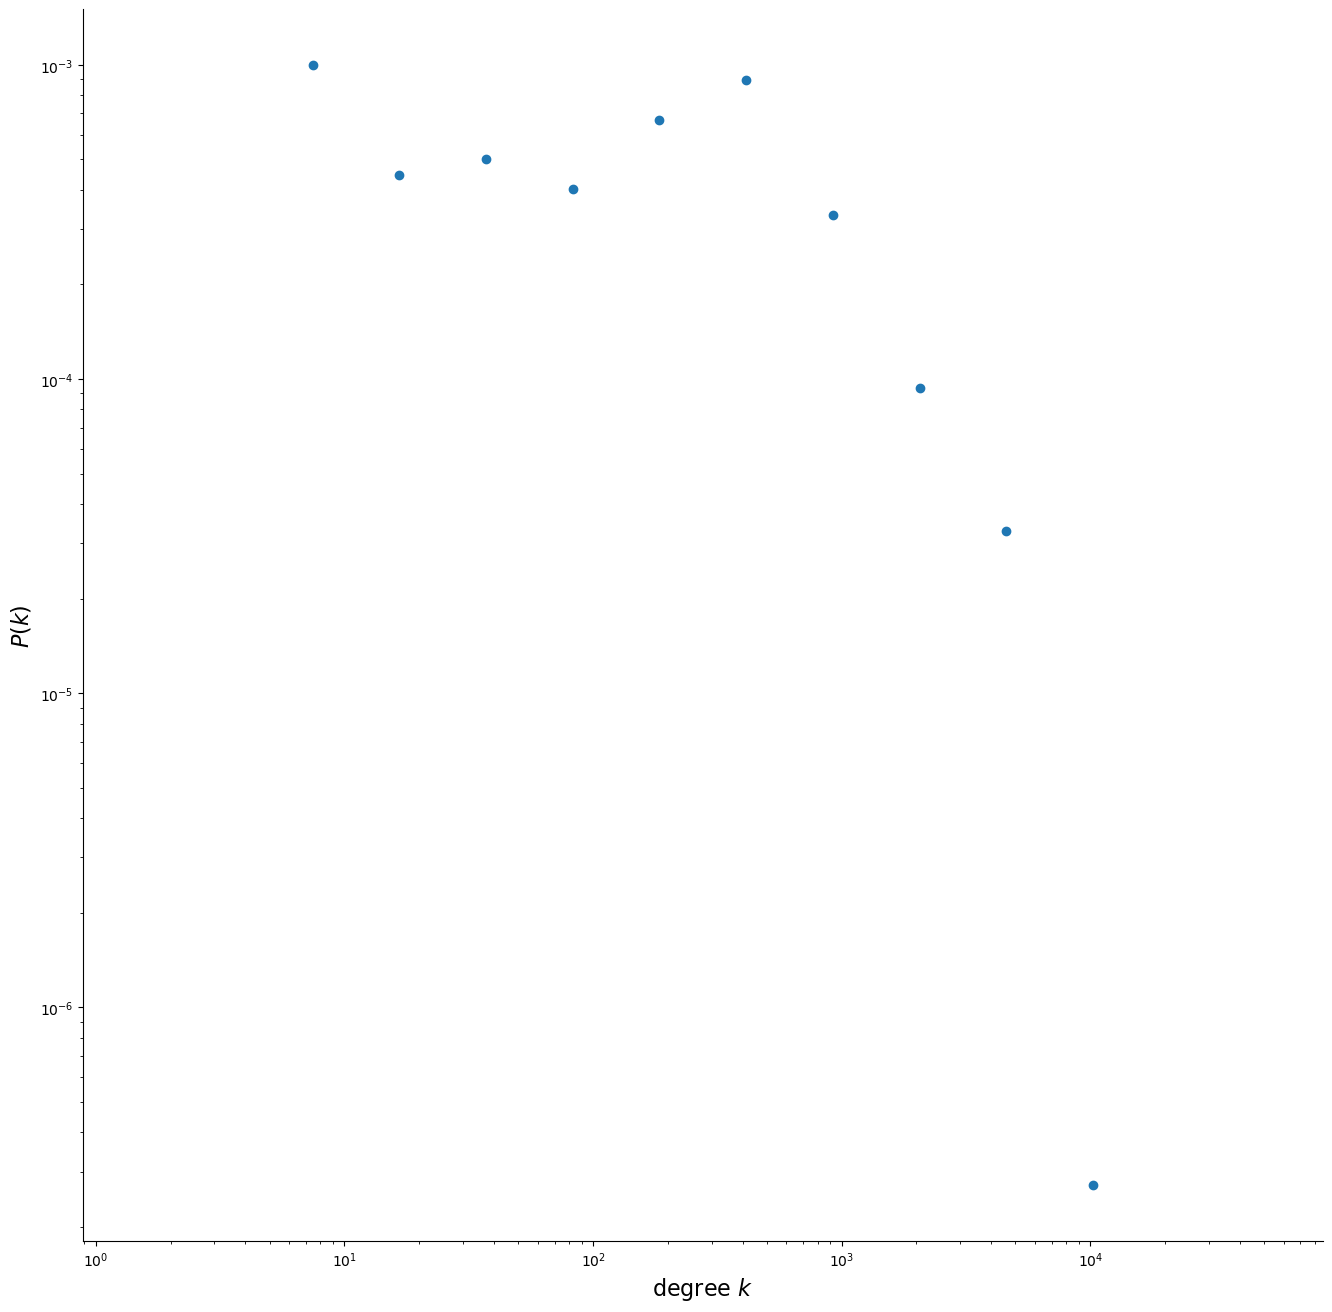

In [71]:
degrees = [G.degree(n, weight = 'weight') for n in G.nodes()]
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print()
print("Weighted average degree:", np.mean(degrees))
print("Minimum degree: ", min(degrees))
print("Maximum degree: ", max(degrees))
print()
plot_degree_dist(G)

In [72]:
print("Unweighted average Clustering Coefficient: ", np.mean(list(nx.clustering(G).values())))

print("Weighted average clustering coefficient: ", nx.average_clustering(G, weight='weight'))

print("Number of connected components: ", nx.number_connected_components(G))

for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
    print("Average shortest path length: ", nx.average_shortest_path_length(C))

Unweighted average Clustering Coefficient:  0.8419293753303101
Weighted average clustering coefficient:  0.02185361197913092
Number of connected components:  11
Average shortest path length:  1.5396927814211503
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
Average shortest path length:  0
